<a href="https://colab.research.google.com/github/guillermocalderon2021/tfm-words-embeddings/blob/main/Notebook_sexismo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<h1><font color='#12007a'>Embeddings contextuales </p>



En concreto, vamos a comparar los siguientes transformers, y los aplicaremos a las tareas de clasificación binaria y clasificación multiclase:


In [ ]:
models = ['bert-base-uncased',
          'distilbert-base-uncased',
          'roberta-base',
          'xlnet-base-cased',
          'gpt2', 't5-small','facebook/bart-base']

model_name = models[1]

TASK = "b" # a, b
TASK = TASK.lower()

print(model_name, TASK)


distilbert-base-uncased b


## Instalar librerías

Debemos instalar las librerías de transformers y datasets:

In [ ]:
import torch
torch.__version__

'2.2.1+cu121'

In [ ]:
!pip install -q transformers[torch] datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00


Para garantizar la reproductividad de nuestros experimentos vamos a fijar una semilla. Con esto conseguimos que las inicializaciones siempre sean las mismas:

In [ ]:
from transformers import set_seed
set_seed(42)

## Dataset

Vamos a cargar el dataset, tal y como ya hicimos en la primera parte de esta práctica:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/data/edos/')

import pandas as pd
df = pd.read_csv("edos_labelled_aggregated.csv")
df.head()

Mounted at /content/drive


,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,none,none,dev
1,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,none,none,train
2,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,none,none,train
3,sexism2022_english-13021,woman?,not sexist,none,none,train
4,sexism2022_english-966,I bet she wished she had a gun,not sexist,none,none,dev


In [ ]:
import multiprocessing
import spacy
import re
import inspect
import numpy as np
from nltk.stem import PorterStemmer


class BaselinePreprocessor:
    """Here, I'll prepare the data for the multi-label classification of the
    baseline model. This class will preprocess the data in a parallel matter using
    multiple processes. The original DataFrame will be split in chunks. A pipeline
    of transformations will be ran on each chunk.
    The pipeline of transformations will include:
    - Text lowercasing
    - Special symbols removal
    - Stopwords removal
    - Stemming (It is chosen for simplicity's sake, using lemmatization will be more resource intensive)

    Args:
        dataset (pandas.DataFrame): The dataset in a DataFrame format.
    """

    def __init__(self, dataset: pd.DataFrame):
        self._df_chunks = np.array_split(dataset, multiprocessing.cpu_count())
        self._spacy_nlp = spacy.load('en_core_web_sm')

        # Getting all defined methods.
        obj_methods = list(inspect.getmembers(self, predicate=inspect.ismethod))
        # Creating a pipeline of actions with only the '_step' methods.
        self._pipeline = [
            reference
            for method_name, reference in obj_methods
            if "_step" in method_name
        ]

    def preprocess(self) -> pd.DataFrame:
        subdfs = []

        with multiprocessing.Pool() as pool:
            results = pool.map(self._run_pipeline, self._df_chunks)

        for result in results:
            subdfs.append(result)

        return pd.concat(subdfs)

    def _run_pipeline(self, df: pd.DataFrame) -> pd.DataFrame:
        for step in self._pipeline:
            df = step(df)

        return df

    def _step_lowercase(self, df: pd.DataFrame) -> pd.DataFrame:
        df["text"] = df["text"].apply(lambda text: text.lower())
        return df

    def _step_remove_special_symbols(self, df: pd.DataFrame) -> pd.DataFrame:
        df["text"] = df["text"].apply(self._remove_special_symbols)
        return df

    def _step_remove_stopwords(self, df) -> pd.DataFrame:
        df["text"] = df["text"].apply(self._remove_stopwords)
        return df

    def _step_stemming(self, df) -> pd.DataFrame:
        df["text"] = df["text"].apply(self._stemming)
        return df

    def _remove_stopwords(self, text: str) -> str:
        doc = self._spacy_nlp(text)

        filtered_words = [
            token.text
            for token in doc
            if not token.is_stop
        ]

        return " ".join(filtered_words)

    def _stemming(self, text: str) -> str:
        stemmer = PorterStemmer()
        stemmed_words = [
            stemmer.stem(token.text)
            for token in self._spacy_nlp(text)
        ]

        return " ".join(stemmed_words)

    def _remove_special_symbols(self, text: str) -> str:
        # Replacing symbols that are not letters, digits or whitespace with a space.
        text = re.sub(r"[^\w\d\s]+", " ", text)
        # Converting multiple whitespaces into single ones.
        text = re.sub(r"\s+", " ", text)

        return text.strip()


bl_preprocessor = BaselinePreprocessor(df)
prep_dataset_df = bl_preprocessor.preprocess()

print("After preprocessing:")
prep_dataset_df.head()

After preprocessing:


,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,nigeria rape woman men rape nsfw nigeria rape ...,not sexist,none,none,dev
1,sexism2022_english-16993,s keeper,not sexist,none,none,train
2,sexism2022_english-13149,like metallica video poor mutil bastard say ki...,not sexist,none,none,train
3,sexism2022_english-13021,woman,not sexist,none,none,train
4,sexism2022_english-966,bet wish gun,not sexist,none,none,dev


Cargamos cada split en un dataframe distinto. Estos dataframe serán transformados en objetos Dataset y usados para construir un DatasetDict que albergue los tres splits de forma conjunta:

In [ ]:
pip install textaugment

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15715 sha256=942b7d24e739dac88979a4e0497f794f8a2c1dedcfb8f488a3b34d49fa342057
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling cha

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pandas as pd
from textaugment import EDA

# Cargar el conjunto de datos desde el archivo CSV
archivo_csv_original = 'edos_labelled_aggregated.csv'
df_original = pd.read_csv(archivo_csv_original)

# Inicializar el objeto de aumentación de datos
eda = EDA()

# Aplicar aumentación de datos a las columnas de texto
columnas_texto = ['text']  # Reemplaza con los nombres reales de tus columnas de texto

for columna in columnas_texto:
    df_original[columna] = df_original[columna].apply(lambda x: eda.random_deletion(x))
    df_original[columna] = df_original[columna].apply(lambda x: eda.random_swap(x))
    #df_original[columna] = df_original[columna].apply(lambda x: eda.random_insertion(x))
    # Puedes agregar más técnicas de aumentación según tus necesidades

# Guardar el nuevo conjunto de datos en otro archivo CSV
archivo_csv_aumentado = 'edos_aug_eda.csv'
df_original.to_csv(archivo_csv_aumentado, index=False)

In [ ]:
df=prep_dataset_df

In [ ]:
df_train_original = df[df['split']=='train']
df_dev = df[df['split']=='dev']
df_test = df[df['split']=='test']

También vamos a cargar un conjunto de instancias cuyos textos fueron generados de forma automática a partir de la librería textaugment:

In [ ]:
df_syn = pd.read_csv("edos_aug_eda.csv")
#df_syn = df_syn.drop(columns=['__index_level_0__'])
df_syn.head()

,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,"rape Nigeria, if you In a woman, the you back!...",not sexist,none,none,dev
1,sexism2022_english-16993,"Then, she's a 😉 keeper.",not sexist,none,none,train
2,sexism2022_english-13149,"This is again, Metallica video where the poor ...",not sexist,none,none,train
3,sexism2022_english-13021,woman?,not sexist,none,none,train
4,sexism2022_english-966,I a she wished she had bet gun,not sexist,none,none,dev


Ahora vamos a concatenar el conjunto de training original y el conjunto que acabamos de cargar con los textos sintéticos:

In [ ]:
#df_train = pd.concat([df_train_original, df_syn])
df_train = pd.concat([df_train_original])
print(df_train_original.shape)
print(df_train.shape)


(14000, 6)
(14000, 6)


In [ ]:
df_train = pd.concat([df_train_original,df_syn])
#df_train = pd.concat([df_train_original])
print(df_train_original.shape)
print(df_train.shape)

(14000, 6)
(34000, 6)


Ahora ya podemos transformar los tres dataframes a objetos Dataset y crear el objeto DatasetDict, que nos facilitará procesar y pasar los datos al modelo transformer:

In [ ]:
# de dataframes a dataset
from datasets import DatasetDict, Dataset
dict_dataset= DatasetDict()
dict_dataset['train'] = Dataset.from_pandas(df_train )
dict_dataset['validation'] = Dataset.from_pandas(df_dev)
dict_dataset['test'] = Dataset.from_pandas(df_test)

# borramos las columnas que nos vamos a utilizar
dict_dataset=dict_dataset.remove_columns(['split','__index_level_0__'])

dict_dataset


DatasetDict({
    train: Dataset({
        features: ['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector'],
        num_rows: 14000
    })
    validation: Dataset({
        features: ['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector'],
        num_rows: 4000
    })
})

Para la tarea B deberemos eliminar todos los mensajes que no están clasificados con la clase 'sexist' en el campo 'label_sexist':

In [ ]:
if TASK != 'a':
    dict_dataset = dict_dataset.filter(lambda example: example["label_sexist"]=='sexist')

# Cada tarea, tiene un nombre de label distinto:
label_task = {'a': 'label_sexist', 'b': 'label_category', 'c':'label_vector'}

# Borramos todas las columnas excepto el texto y el campo label correspondiente a la tarea
columns_to_remove = list(set(dict_dataset['train'].features) - set(['text', label_task[TASK]]))
dict_dataset = dict_dataset.remove_columns(columns_to_remove)
# renombramos el campo label específico de la tarea a label
print('renombramos: ', label_task[TASK])
dict_dataset = dict_dataset.rename_column(label_task[TASK],'label')
dict_dataset

Filter:   0%|          | 0/14000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

renombramos:  label_category


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3398
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 486
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 970
    })
})

### Label encoding

Las labels en este dataset son textos. Así, por ejemplo, para la tarea A, las labels son: 'not sexist' y 'sexist'.
Para la tarea B, las labels son:
- 1. threats, plans to harm and incitement
- 2. derogation
- 3. animosity
- 4. prejudiced discussions

Las labels deben ser transformadas en números enteros. Para ello usaremos la clase LabelEncoder de sklearn:

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# entrenamos el codificador de etiquetas
le.fit(dict_dataset['train']['label'])
# guardamos el conjunto de labels y su número
LABELS = list(le.classes_)
NUM_LABELS = len(LABELS)

# transformamos las etiquetas de texto a número en los tres splits
# las guardamos en tres listas
y_train = le.transform(dict_dataset['train']['label'])
y_val = le.transform(dict_dataset['validation']['label'])
y_test = le.transform(dict_dataset['test']['label'])




Vamos a comprobar que en efecto la transformación se ha hecho de forma correcta. Tomamos, por ejemplo, las 5 primero labels del conjunto test y vemos que se han codificado correctamente:

In [ ]:
print(dict_dataset['test']['label'][:5])
print(y_test[:5])

['2. derogation', '2. derogation', '2. derogation', '2. derogation', '2. derogation']
[1 1 1 1 1]


# Baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(dict_dataset['train']['text'])
vectors_val = vectorizer.transform(dict_dataset['validation']['text'])
vectors_test = vectorizer.transform(dict_dataset['test']['text'])

In [ ]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
def create_mlp():
    mlp = Sequential()
    mlp.add(Dense(256, activation='relu'))
    mlp.add(Dense(4, activation='softmax'))

    return mlp


mlp = create_mlp()

In [ ]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
import keras
import tensorflow as tf
#import tensorflow_addons as tfa

# Here, I'll the define hyperparameters, loss function and optimizer of the Baseline MLP.
L_RATE = 1e-3
LOSS_FUNC = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
OPTIMIZER = keras.optimizers.Adam(learning_rate=L_RATE)
EPOCHS = 15
BATCH_SIZE = 32

METRICS = [
    keras.metrics.Precision(name="Precision"),
    tfa.metrics.F1Score(
        name="F1-Score",
        num_classes=4,
        # Since the dataset is imbalanced, I'll use micro averaging.
        average="micro"

    )
]

In [ ]:
vectors_val[0]

<1x6415 sparse matrix of type '<class 'numpy.float64'>'
	with 18 stored elements in Compressed Sparse Row format>

In [ ]:
def make_prediction(model: Sequential, X: np.ndarray) -> np.ndarray:
    """Making a prediction with the MLP model for multiclass classification.

    Args:
        model (Sequential): The model object.
        X (numpy.ndarray): The feature matrix.

    Returns:
        np.ndarray: The predicted class labels.
    """
    y_pred = model.predict(X)
    # Retorna el índice de la clase con la probabilidad más alta
    return np.argmax(y_pred, axis=1)


mlp.compile(loss='sparse_categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

vectors_train.sort_indices()
vectors_val.sort_indices()
#vectors_test = tf.sparse.reorder(vectors_test)

# Asumiendo que X_train y y_train están correctamente preprocesados y formateados
mlp.fit(
    vectors_train,
    y_train,
    validation_data=(vectors_val, y_val),
    epochs=EPOCHS,  # Asegúrate de que EPOCHS está definido
    batch_size=BATCH_SIZE  # Asegúrate de que BATCH_SIZE está definido
)

Epoch 1/15
107/107 [==============================] - 14s 121ms/step - loss: 1.1863 - accuracy: 0.4673 - val_loss: 1.0962 - val_accuracy: 0.5123
Epoch 2/15
107/107 [==============================] - 4s 38ms/step - loss: 0.9246 - accuracy: 0.6248 - val_loss: 1.0155 - val_accuracy: 0.5247
Epoch 3/15
107/107 [==============================] - 1s 12ms/step - loss: 0.5811 - accuracy: 0.8158 - val_loss: 1.0416 - val_accuracy: 0.5494
Epoch 4/15
107/107 [==============================] - 1s 13ms/step - loss: 0.3081 - accuracy: 0.9253 - val_loss: 1.1649 - val_accuracy: 0.5432
Epoch 5/15
107/107 [==============================] - 1s 12ms/step - loss: 0.1733 - accuracy: 0.9665 - val_loss: 1.3124 - val_accuracy: 0.5391
Epoch 6/15
107/107 [==============================] - 1s 9ms/step - loss: 0.1044 - accuracy: 0.9850 - val_loss: 1.4533 - val_accuracy: 0.5391
Epoch 7/15
107/107 [==============================] - 1s 9ms/step - loss: 0.0678 - accuracy: 0.9926 - val_loss: 1.5643 - val_accuracy: 0.5309

In [ ]:
vectors_test.sort_indices()
y_pred = make_prediction(model=mlp, X=vectors_test)

31/31 [==============================] - 0s 3ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
print(classification_report(y_true = y_test, y_pred = y_pred, target_names = LABELS))

micro_f1 = f1_score(y_true = y_test, y_pred = y_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.51      0.37      0.43        89
                           2. derogation       0.53      0.59      0.56       454
                            3. animosity       0.39      0.41      0.40       333
               4. prejudiced discussions       0.53      0.30      0.38        94

                                accuracy                           0.48       970
                               macro avg       0.49      0.42      0.44       970
                            weighted avg       0.48      0.48      0.47       970

Micro-F1 Score: 0.4773


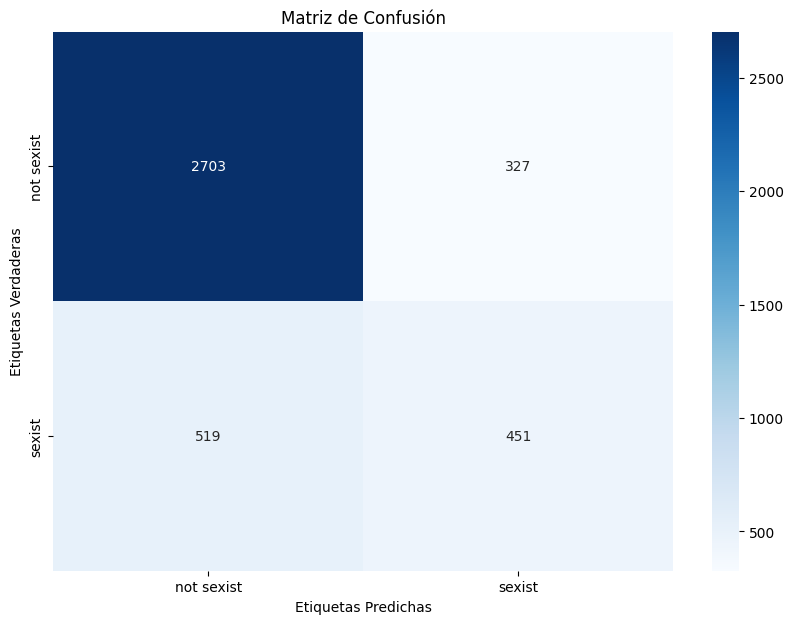

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)



# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

## Tokenización

Siempre es necesario cargar el tokenizador asociado con el transformer que vayamos a utilizar.


In [ ]:
if 'uncased' in model_name:
        do_lower_case = True
else:
        do_lower_case = False

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=do_lower_case)


In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)
print(model_name, ' cargado')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


distilbert-base-uncased  cargado


### Tamaño de los textos


In [ ]:
# obtenemos la longitud de la secuencia más larga en el conjunto de training
MAX_LENGTH = max([len(tokenizer(text).tokens())  for text in dict_dataset['train']['text']])
print(MAX_LENGTH)


93


Vemos que el tamaño máximo es de 93 tokens. En realidad, en esos 93 tokens habrá tokens y también subtokens, porque los tokenizadores de los transformers dividien las palabras desconocidas (es decir, aquellas que no están en la colección de textos utilizada para pre-entrenar el modelo) en subtokens para que puedan ser represenatdos.

El tamaño máximo que permiten la mayoría de los modelos es 512, así que podríamos preparar nuestras entradas para que tuvieran esa longitud, pero en realidad usando una longitud de 93, vamos a representar todas los textos de nuestro dataset, y además, vamos a ahorrar recursos.

In [ ]:
MAX_LENGTH = min(MAX_LENGTH, 512)
print('MAX_LENGTH:', MAX_LENGTH)

MAX_LENGTH: 93


Una vez que ya hemos estimado el tamaño máximo de nuestras secuencias (textos) de entrada, ya podemos definir nuestra función para tokenizar todos los textos de los tres splits.

Es necesario el parámetro **truncation** igual a True, porque en el conjunto de validación o en el conjunto test, podría existir algún texto con un número mayor de tokens.



In [ ]:
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding=True, max_length=MAX_LENGTH)


In [ ]:

tokenizer.pad_token = tokenizer.eos_token
# set the pad token of the model's configuration
model.config.pad_token_id = model.config.eos_token_id
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

Una vez definida la función, la aplicamos sobre todo el dataset, gracias a la función map. Además, vamos a borrar la columna text.

La columna 'label' también la eliminamos porque sus valores están en formato string. Lo que hacemos es eliminar dicha columna y volver a añadirla en cada split, pero ahora guardando los valores de las labels ya codificados (transformados a números):

In [ ]:
encoded_dataset = dict_dataset.map(tokenize, batched=True)
# quitamos text y label. label se quita porque sus valores son string
encoded_dataset = encoded_dataset.remove_columns(['text','label'])
# añadimos a cada split la columna label otra vez, pero ahora con sus correspodientes valores transformados a números (lo hicimos en Label encoding)
encoded_dataset['train'] = encoded_dataset['train'].add_column('label', y_train)
encoded_dataset['validation'] = encoded_dataset['validation'].add_column('label', y_val)
# además, borramos la codificación de test, porque realmente no se va a usar durante el entrenamiento
del(encoded_dataset['test'] )
encoded_dataset

Map:   0%|          | 0/8252 [00:00<?, ? examples/s]

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 8252
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 486
    })
})

In [ ]:
type(len(encoded_dataset['train']['input_ids'][0]))

int

## Modelo

In [ ]:
# define metrics
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='micro')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,    #we could return just the accuracy
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



 usaremos la clase TrainingArguments que ya tiene los hiper-parámetros definidos e inicializados para este tipo de tareas.

In [ ]:

from transformers import TrainingArguments
args = TrainingArguments(
    output_dir='./outputs/',
    # overwrite_output_dir = True,  # If `True`, overwrite the content of the output directory. Use this to continue training if `output_dir` points to a checkpoint directory.
    logging_dir='./logs',
    num_train_epochs=5, # usa 1 para un entrenamiento rápido, aunque lo recomendable es un valor de 3 a 5
    evaluation_strategy = "epoch",  # "steps",   evaluate each `logging_steps`, logging_steps=400,               # log & save weights each logging_steps     save_steps=400,
                                    # save_steps=400,
    save_strategy = "no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model="f1",

)

Ya estamos listos para crear el objeto Trainer, al que pasamos el modelo, el tokenizador, los argumentos, la función que cálcula las métricas, y los datos codificados de training y validación:

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,                                  # the model
    args,                                   # the arguments of the model
    train_dataset=encoded_dataset['train'],               # the training dataset
    eval_dataset=encoded_dataset['validation'],               #the validation dataset
    tokenizer=tokenizer,                    # the tokenizer
    compute_metrics=compute_metrics,        # the metrics used to evaluate the validation, these are calculated in each epoch
)
0
# training
print('Training: ', model_name)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training:  distilbert-base-uncased


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.975600,0.842632,0.652263,0.652263,0.652263,0.652263
2,0.670300,0.811918,0.658436,0.658436,0.658436,0.658436
3,0.396900,0.748512,0.713992,0.713992,0.713992,0.713992
4,0.225400,0.842576,0.724280,0.724280,0.724280,0.724280
5,0.142900,0.908639,0.726337,0.726337,0.726337,0.726337


TrainOutput(global_step=2580, training_loss=0.47102669412775555, metrics={'train_runtime': 356.6181, 'train_samples_per_second': 115.698, 'train_steps_per_second': 7.235, 'total_flos': 988276193473632.0, 'train_loss': 0.47102669412775555, 'epoch': 5.0})

Evaluando el mejor modelo obtenido durante el training sobre el conjunto de validación:

In [ ]:
result = trainer.evaluate()
result

{'eval_loss': 0.9964725971221924,
 'eval_accuracy': 0.7119341563786008,
 'eval_f1': 0.7119341563786008,
 'eval_precision': 0.7119341563786008,
 'eval_recall': 0.7119341563786008,
 'eval_runtime': 0.715,
 'eval_samples_per_second': 679.763,
 'eval_steps_per_second': 43.359,
 'epoch': 5.0}

### Guardar el modelo

 El modelo se almacena en la subcarpeta models. Es necesario guardar el tokenizador y el modelo.


In [ ]:
import os
SAVE_MODEL = False
if SAVE_MODEL:
    models_dir = 'models2/'
    if not os.path.exists(models_dir): ### If the file directory doesn't already exists,
        os.makedirs(models_dir) ### Make it please

    model_path = models_dir+model_name
    model_path += "_{}".format(TASK)

    # grabamos el modelo y el tokenizador
    tokenizer.save_pretrained(model_path)
    trainer.save_model(model_path)

Una vez entrenado el modelo, podemos usarlo sobre los textos del conjunto test para inferir sus etiquetas. Estas se comparán con las del conjunto test, y se podrán obtener los resultados finales:


In [ ]:
def get_prediction(text):
    # recibe el texto y lo tokeniza usando la misma función que se uso para el training
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=MAX_LENGTH, return_tensors="pt").to("cuda")
    # aplica el modelo sobre la entrada
    outputs = model(**inputs)
    # recupera las probabilidades
    probs = outputs[0].softmax(1)
    # la función argmax nos devuelve la clase con mayor probabilidad
    # devuelve el nombre de la clase, no su codificación
    return probs.argmax().item()

Aplicamos la función get_prediction sobre todos los textos del conjunto test, y además recuperamos las labels del conjunto test:

In [ ]:
y_pred=[LABELS[get_prediction(text)] for text in dict_dataset['test']['text']]


Recuperamos las labels del conjunto (sin codificar):

In [ ]:
y_test = dict_dataset['test']['label']
print(y_test[:5])
print(y_pred[:5])

['2. derogation', '2. derogation', '2. derogation', '2. derogation', '2. derogation']
['3. animosity', '2. derogation', '2. derogation', '2. derogation', '2. derogation']


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
print(classification_report(y_true = y_test, y_pred = y_pred, target_names=LABELS))
micro_f1 = f1_score(y_true = y_test, y_pred = y_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))


                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.79      0.49      0.61        89
                           2. derogation       0.76      0.70      0.73       454
                            3. animosity       0.62      0.74      0.68       333
               4. prejudiced discussions       0.63      0.68      0.66        94

                                accuracy                           0.69       970
                               macro avg       0.70      0.65      0.67       970
                            weighted avg       0.70      0.69      0.69       970

Micro-F1 Score: 0.6938


Almacenando los resultados para poder compararlos con lso de los otros modelos:

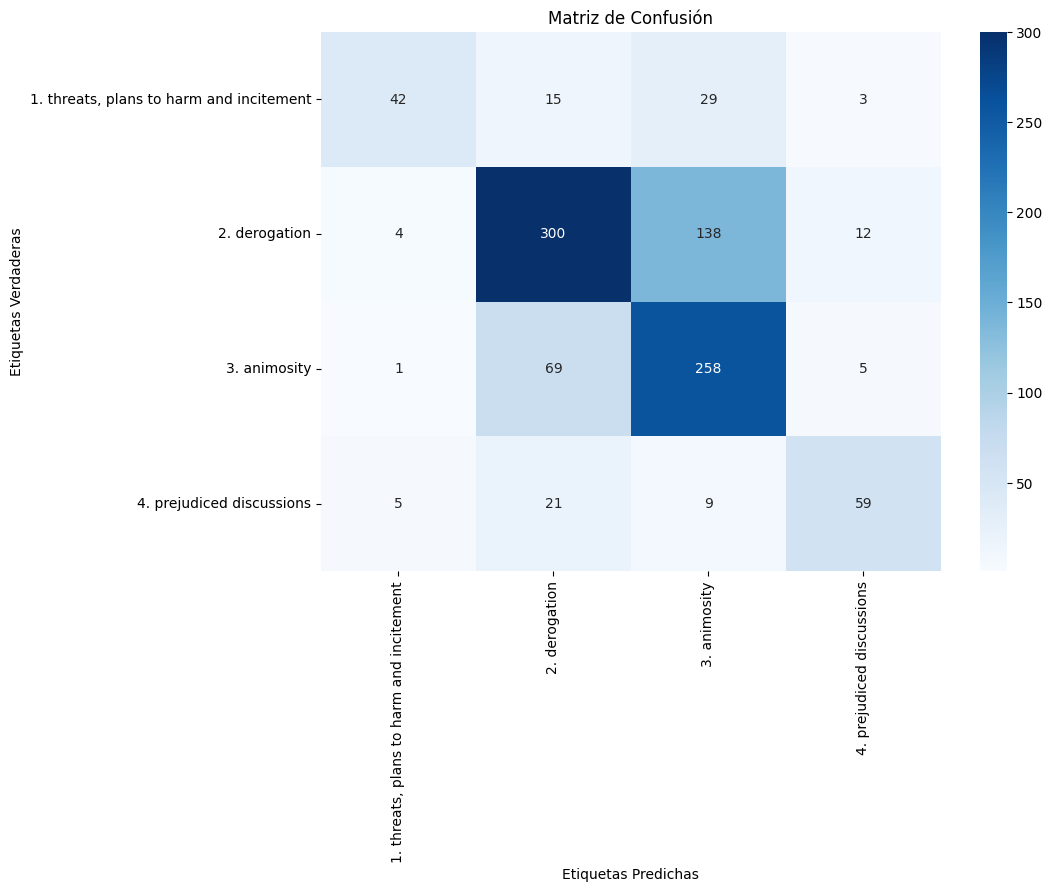

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)



# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
import os
output_dir = 'results_3/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, target_names=LABELS, output_dict=True)).transpose()
path_results = output_dir+model_name

clsf_report.to_csv(path_results+'_{}.csv'.format(TASK), index= True)
print(path_results+'_{}.csv'.format(TASK), ' grabado!')


results_3/distilbert-base-uncased_b.csv  grabado!


In [ ]:
from transformers import AutoModel
model = AutoModel.from_pretrained(model_name, num_labels=NUM_LABELS)
print(model_name, ' cargado')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

distilbert-base-uncased  cargado


In [ ]:
def get_embeddings(dataset):
  cls_embeddings_list = []
  for text in dataset:
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)


    model.eval()
    with torch.no_grad():
      outputs = model(**inputs)

    # Extraer el vector [CLS] para cada input
    cls_embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()

    cls_embeddings_list.append(cls_embeddings)
  return np.vstack(cls_embeddings_list)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
def get_embeddings(dataset):
    # Tokenizar el dataset
    inputs = tokenizer(dataset, padding=True, truncation=True, return_tensors="pt", max_length=512)

    # Crear DataLoader
    batch_size = 32  # Ajusta esto según tu GPU
    data_loader = DataLoader(TensorDataset(inputs['input_ids'], inputs['attention_mask']), batch_size=batch_size)

    cls_embeddings_list = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask = [b.to(model.device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Extraer el vector [CLS] para cada input en el batch
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            cls_embeddings_list.append(cls_embeddings)

    # Concatenar todos los embeddings de los lotes
    return np.vstack(cls_embeddings_list)

In [ ]:
vectors_train=get_embeddings(dict_dataset['validation']['text'])


In [ ]:
vectors_test=get_embeddings(dict_dataset['test']['text'])

In [ ]:
vectors_test ,vectors_train = vectors_train ,vectors_test

In [ ]:
y_train=y_test
y_test=y_val

In [ ]:
vectors_train.shape

(4000, 768)

In [ ]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Definir el clasificador SVM
svm_clf = SVC()

# Definir la grilla de parámetros para la búsqueda
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Realizar la búsqueda en grilla con validación cruzada
grid_search = HalvingGridSearchCV(svm_clf, param_grid, cv=3, scoring='f1_micro',verbose=3)
grid_search.fit(vectors_train, y_train)

# Obtener el mejor clasificador
best_svm_clf = grid_search.best_estimator_


# Evaluar el mejor clasificador en el conjunto de prueba
y_test_pred = best_svm_clf.predict(vectors_test)
print('Métricas en el conjunto de prueba:')
print(classification_report(y_test, y_test_pred))
micro_f1 = f1_score(y_test, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 148
max_resources_: 4000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 148
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.684, test=0.735) total time=   0.0s
[CV 2/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.765, test=0.857) total time=   0.0s
[CV 3/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.755, test=0.735) total time=   0.0s
[CV 1/3] END C=0.1, gamma=1, kernel=linear;, score=(train=0.949, test=0.673) total time=   0.0s
[CV 2/3] END C=0.1, gamma=1, kernel=linear;, score=(train=0.837, test=0.857) total time=   0.0s
[CV 3/3] END C=0.1, gamma=1, kernel=linear;, score=(train=0.837, test=0.694) total time=   0.0s
[CV 1/3] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.684, test=0.735) total time=   0.0s
[CV 2/3] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.765, test=0.857) t

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report

# Definir el clasificador Random Forest
rf_clf = RandomForestClassifier()

# Definir la grilla de parámetros para la búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt']
}


# Realizar la búsqueda en grilla con validación cruzada
grid_search = HalvingGridSearchCV(rf_clf, param_grid, cv=3, scoring='f1_micro',verbose=3)
grid_search.fit(vectors_train, y_train)

# Obtener el mejor clasificador
best_rf_clf = grid_search.best_estimator_


# Evaluar el mejor clasificador en el conjunto de prueba
y_test_pred = best_rf_clf.predict(vectors_test)
print('Métricas en el conjunto de prueba:')
print(classification_report(y_test, y_test_pred,target_names=LABELS))
micro_f1 = f1_score(y_test, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 49
max_resources_: 4000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 49
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.812) total time=   0.1s
[CV 2/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.750) total time=   0.1s
[CV 3/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.625) total time=   0.1s
[CV 1/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=1.000, test=0.875) total time=   0.3s
[CV 2/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20

In [ ]:
from xgboost import XGBClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Definir el clasificador XGBoost
#xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',objective='multi:softmax', num_class=20, random_state=42)

# Definir la grilla de parámetros para la búsqueda
param_grid = {
    'max_depth': [3, 6],#, 9],
    'learning_rate': [ 0.01],#, 0.001],
    'subsample': [0.8 ]#, 1]
}


# Realizar la búsqueda en grilla con validación cruzada
#grid_search = HalvingGridSearchCV(xgb_clf, param_grid, cv=3, scoring='f1_micro',verbose=3)
#grid_search.fit(vectors_train, y_train_num)

# Obtener el mejor clasificador
#best_xgb_clf = grid_search.best_estimator_

xgb_clf = XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.1)

xgb_clf.fit(vectors_train, y_train, verbose=3)

# Evaluar el mejor clasificador en el conjunto de prueba
y_test_pred = xgb_clf.predict(vectors_test)
print('Métricas en el conjunto de prueba:')
print(classification_report(y_test, y_test_pred,target_names=LABELS))
micro_f1 = f1_score(y_test, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

Métricas en el conjunto de prueba:
              precision    recall  f1-score   support

  not sexist       0.80      0.95      0.87      1514
      sexist       0.61      0.25      0.35       486

    accuracy                           0.78      2000
   macro avg       0.70      0.60      0.61      2000
weighted avg       0.75      0.78      0.74      2000

Micro-F1 Score: 1.0000


In [ ]:
micro_f1 = f1_score(y_test, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

Micro-F1 Score: 0.7790


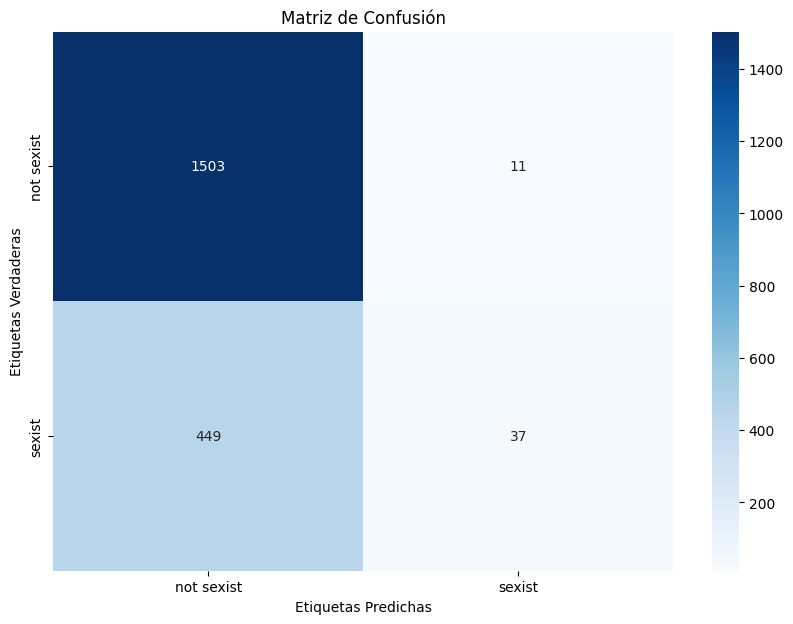

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)



# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()